**Random Forest Regressor**

The Random Forest Regressor is an ensemble learning method for regression tasks that builds a collection of decision trees and aggregates their predictions to improve accuracy and generalization. Each tree is trained on a bootstrapped sample of the training data and considers a random subset of features at each split, which introduces diversity and reduces overfitting compared to a single decision tree. Predictions are obtained by averaging the outputs of all individual trees, making the model robust to noise, outliers, and multicollinearity in the data. Random Forests can capture nonlinear relationships and feature interactions automatically, require minimal feature scaling, and provide feature importance metrics, making them highly effective for a wide range of tabular regression problems.

In [1]:
!pip install shap category_encoders pdpbox


In [3]:
import os, sys, random, warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn: preprocessing, modeling, evaluation ---
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# --- Explainability ---
import shap
from pdpbox import pdp
# --- Encoders for categorical features ---
import category_encoders as ce
# --- Model persistence ---
import joblib
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# --- Random Seed for reproducibility ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# --- Print versions (useful for reproducibility logs) ---
import sklearn
print(" Setup complete!")
print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"SHAP version: {shap.__version__}")




 Setup complete!
Python version: 3.12.11
Pandas version: 2.2.2
NumPy version: 2.0.2
scikit-learn version: 1.6.1
SHAP version: 0.48.0


In [5]:
from sklearn.datasets import fetch_california_housing

# Load dataset as pandas DataFrame
data = fetch_california_housing(as_frame=True)

# Extract features (X) and target (y)
df = data.frame.copy()
target = 'MedHouseVal'  # target column name (median house value)

# Display basic information
print(" Dataset loaded successfully!")
print(f"Shape of dataset: {df.shape}")
print(f"Feature names: {list(data.feature_names)}")
print(f"Target variable: {target}")

# Preview first 5 rows
print("\n🔹 First 5 rows of the dataset:")
display(df.head())

 Dataset loaded successfully!
Shape of dataset: (20640, 9)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target variable: MedHouseVal

🔹 First 5 rows of the dataset:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [8]:
print(" Basic descriptive statistics:")
display(df.describe().T)

 Basic descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [11]:
print(" Number of missing values per column:")
missing_table = df.isna().sum().sort_values(ascending=False)
display(missing_table)

 Number of missing values per column:


,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


In [12]:
print("🔹 Number of unique values in each column:")
unique_counts = df.nunique().sort_values(ascending=False)
display(unique_counts)

🔹 Number of unique values in each column:


,0
AveRooms,19392
AveOccup,18841
AveBedrms,14233
MedInc,12928
Population,3888
MedHouseVal,3842
Latitude,862
Longitude,844
HouseAge,52


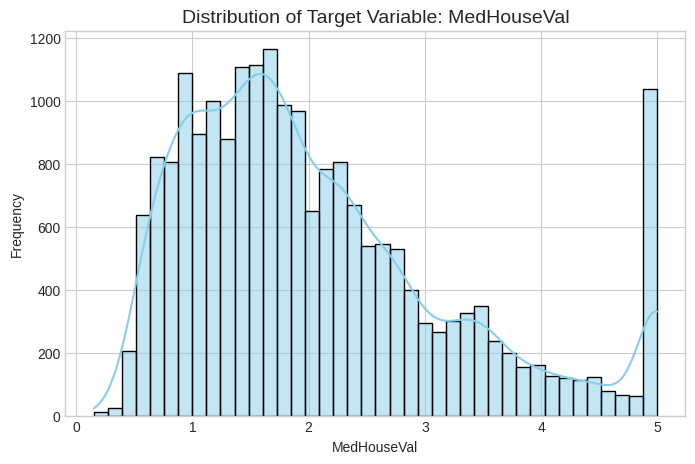

In [13]:
target = 'MedHouseVal'  # Target variable

plt.figure(figsize=(8,5))
sns.histplot(df[target], kde=True, bins=40, color='skyblue')
plt.title(f"Distribution of Target Variable: {target}", fontsize=14)
plt.xlabel(target)
plt.ylabel("Frequency")
plt.show()

In [15]:
#  Check Skewness
skewness_value = df[target].skew()
print(f"Skewness of '{target}': {skewness_value:.3f}")

if skewness_value > 1:
    print(" Highly right-skewed distribution — consider log-transform.")
elif skewness_value > 0.5:
    print("ℹ Moderately right-skewed — log-transform might help.")
else:
    print("Fairly symmetric distribution — log-transform likely not needed.")


Skewness of 'MedHouseVal': 0.978
ℹ Moderately right-skewed — log-transform might help.


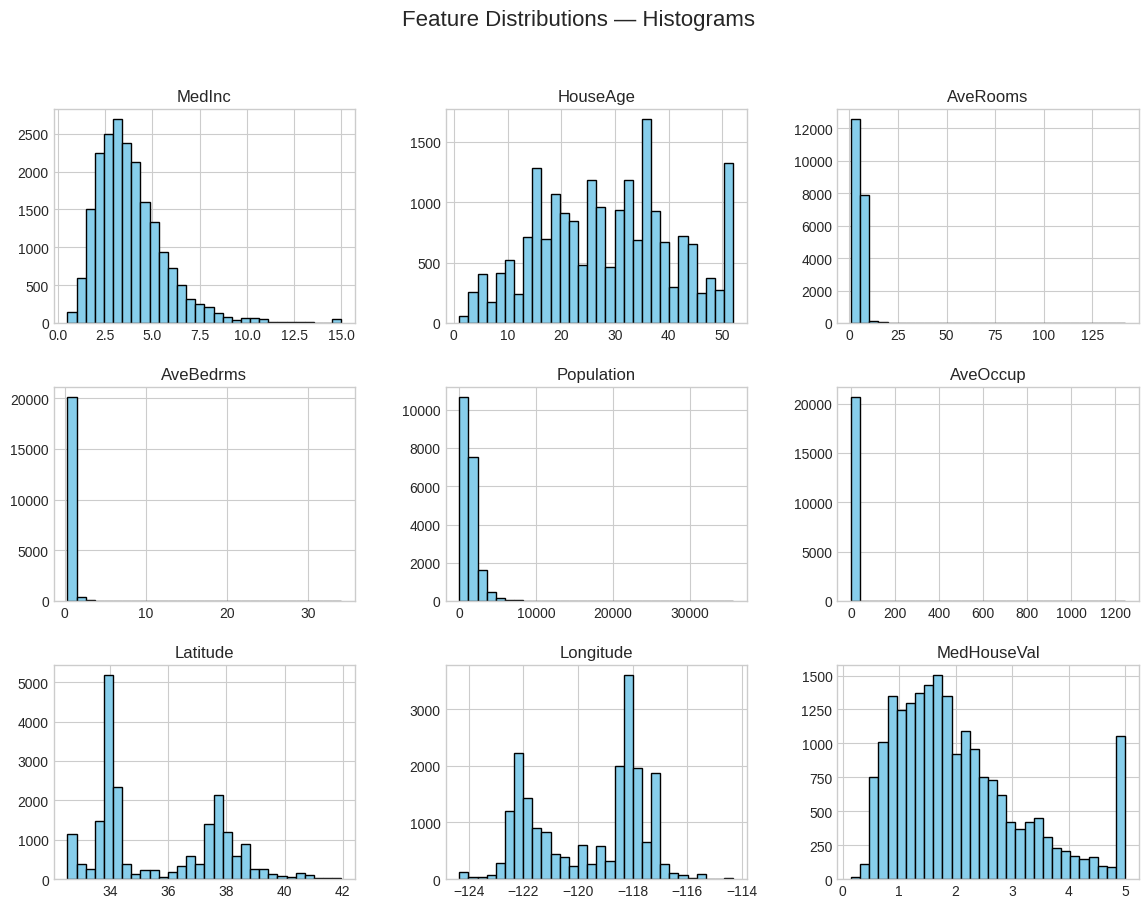

In [16]:

# Feature Distributions — Histograms


# Select only numeric columns (exclude target)
numeric_cols = df.select_dtypes(include=np.number).columns.drop(['MedHouseVal_log'], errors='ignore')

# Plot histograms for all numeric features
df[numeric_cols].hist(
    figsize=(14, 10), bins=30, edgecolor='black', color='skyblue'
)
plt.suptitle("Feature Distributions — Histograms", fontsize=16)
plt.show()


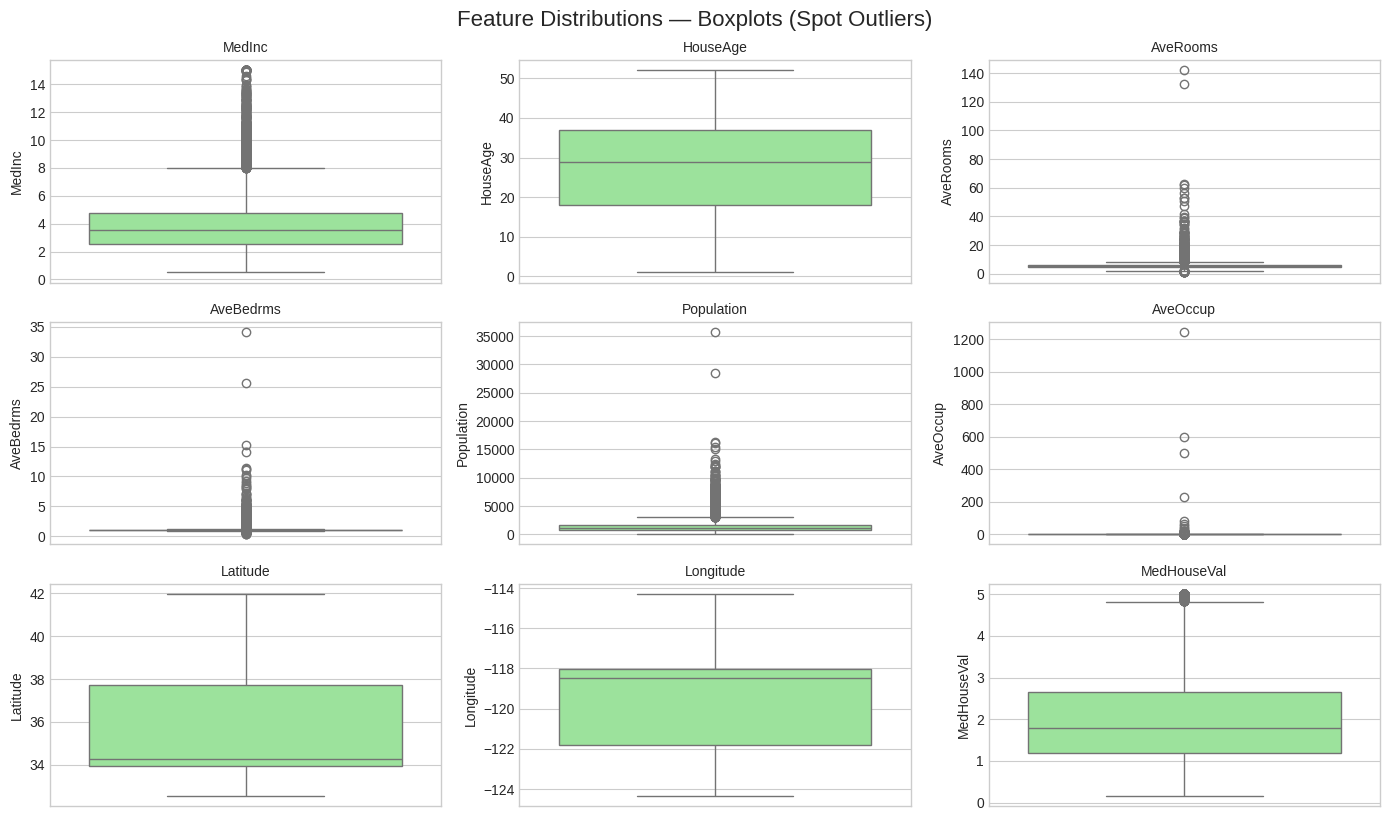

In [17]:
plt.figure(figsize=(14, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(int(np.ceil(len(numeric_cols)/3)), 3, i)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.suptitle("Feature Distributions — Boxplots (Spot Outliers)", fontsize=16, y=1.02)
plt.show()

In [19]:
# Correlation Matrix (Numerical Features)
# Select only numeric columns (excluding log target for now)
numeric_cols = df.select_dtypes(include=np.number).columns.drop(['MedHouseVal_log'], errors='ignore')

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Display top correlations with the target variable
target = 'MedHouseVal'
print(f" Top correlations with target '{target}':\n")
display(corr_matrix[target].sort_values(ascending=False))

# Display entire correlation matrix
print("\n Full correlation matrix (rounded):")
display(corr_matrix.round(2))

 Top correlations with target 'MedHouseVal':



,MedHouseVal
MedHouseVal,1.000000
MedInc,0.688075
AveRooms,0.151948
HouseAge,0.105623
AveOccup,-0.023737
Population,-0.024650
Longitude,-0.045967
AveBedrms,-0.046701
Latitude,-0.144160



 Full correlation matrix (rounded):


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.00,-0.12,0.33,-0.06,0.00,0.02,-0.08,-0.02,0.69
HouseAge,-0.12,1.00,-0.15,-0.08,-0.30,0.01,0.01,-0.11,0.11
AveRooms,0.33,-0.15,1.00,0.85,-0.07,-0.00,0.11,-0.03,0.15
AveBedrms,-0.06,-0.08,0.85,1.00,-0.07,-0.01,0.07,0.01,-0.05
Population,0.00,-0.30,-0.07,-0.07,1.00,0.07,-0.11,0.10,-0.02
AveOccup,0.02,0.01,-0.00,-0.01,0.07,1.00,0.00,0.00,-0.02
Latitude,-0.08,0.01,0.11,0.07,-0.11,0.00,1.00,-0.92,-0.14
Longitude,-0.02,-0.11,-0.03,0.01,0.10,0.00,-0.92,1.00,-0.05
MedHouseVal,0.69,0.11,0.15,-0.05,-0.02,-0.02,-0.14,-0.05,1.00


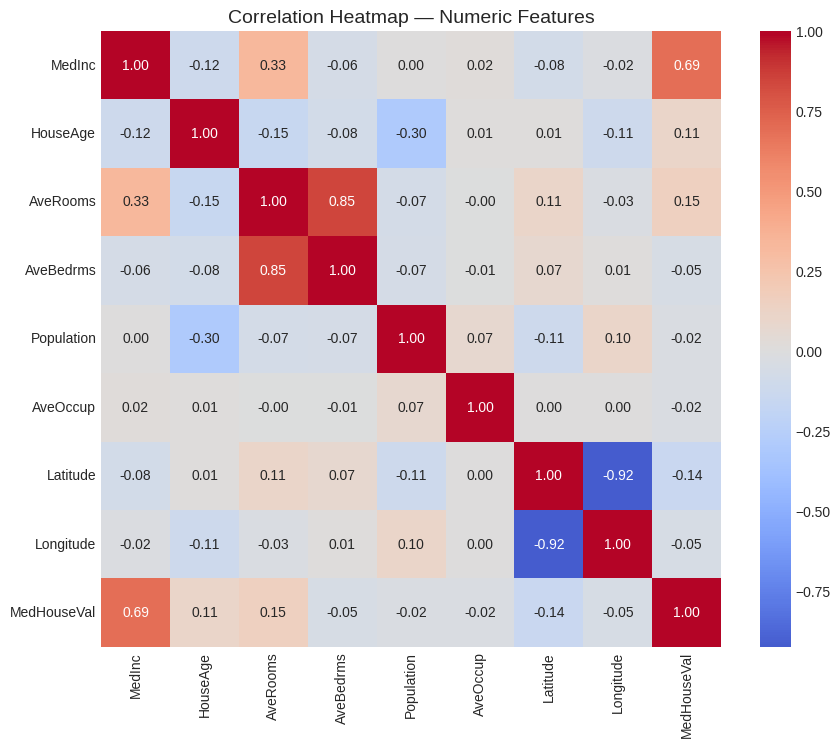

In [20]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap — Numeric Features", fontsize=14)
plt.show()

In [23]:
#  Detect Highly Correlated Features (Multicollinearity)
# Set correlation threshold
threshold = 0.85

# Find pairs of features with high correlation (excluding self-correlation)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs['Correlation']) > threshold]

if not high_corr_pairs.empty:
    print(f"Highly correlated feature pairs (|corr| > {threshold}):")
    display(high_corr_pairs.sort_values(by='Correlation', ascending=False))
else:
    print(f" No pairs of features with correlation above {threshold}")


Highly correlated feature pairs (|corr| > 0.85):


,Feature_1,Feature_2,Correlation
33,Latitude,Longitude,-0.924664


In [25]:
#Create Binned Versions of Continuous Features (for grouping)
df['HouseAge_bin'] = pd.cut(df['HouseAge'], bins=[0, 10, 20, 30, 40, 50], labels=['0-10', '11-20', '21-30', '31-40', '41-50'])
df['AveRooms_bin'] = pd.qcut(df['AveRooms'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

print(" Created binned categorical columns:")
print(df[['HouseAge', 'HouseAge_bin', 'AveRooms', 'AveRooms_bin']].head())

 Created binned categorical columns:
   HouseAge HouseAge_bin  AveRooms AveRooms_bin
0      41.0        41-50  6.984127    Very High
1      21.0        21-30  6.238137    Very High
2      52.0          NaN  8.288136    Very High
3      52.0          NaN  5.817352         High
4      52.0          NaN  6.281853    Very High



🔹 Aggregations for HouseAge_bin vs MedHouseVal


,mean,median,count
HouseAge_bin,,,
0-10,2.002633,1.7040,1569
11-20,1.911816,1.6610,4724
21-30,2.068016,1.8485,4852
31-40,2.066622,1.8000,5617
41-50,2.058604,1.7150,2557


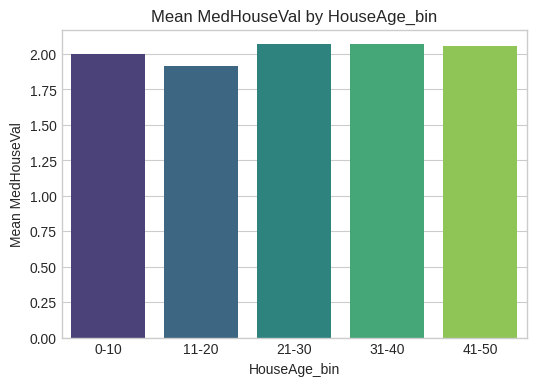


🔹 Aggregations for AveRooms_bin vs MedHouseVal


,mean,median,count
AveRooms_bin,,,
Low,1.823917,1.6250,5160
Medium,1.780122,1.6165,5160
High,1.945912,1.7540,5161
Very High,2.724433,2.5620,5159


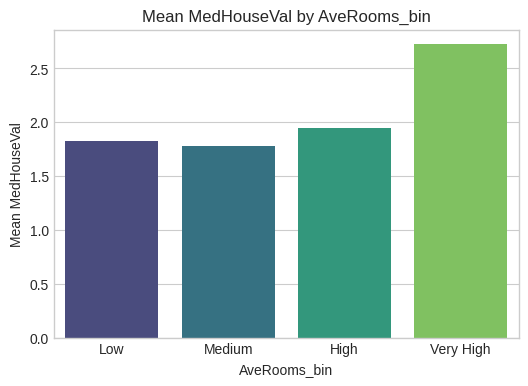

In [27]:
# Grouped Aggregations: Feature vs Target

target = 'MedHouseVal'
# Choose columns to group by (categorical or newly binned)
group_cols = ['HouseAge_bin', 'AveRooms_bin']
for col in group_cols:
    print(f"\n🔹 Aggregations for {col} vs {target}")
    agg_df = df.groupby(col)[target].agg(['mean', 'median', 'count']).sort_index()
    display(agg_df)

    # Optional: visualize
    plt.figure(figsize=(6,4))
    sns.barplot(x=agg_df.index, y=agg_df['mean'], palette='viridis')
    plt.title(f"Mean {target} by {col}")
    plt.ylabel(f"Mean {target}")
    plt.xlabel(col)
    plt.show()

**Feature Engineering:**

In [29]:
# Domain-specific / Ratio Features
# Rooms per household
df['RoomsPerHousehold'] = df['AveRooms'] / df['AveOccup']

# Bedrooms per room
df['BedroomsPerRoom'] = df['AveBedrms'] / df['AveRooms']

# Population per household
df['PopulationPerHousehold'] = df['Population'] / df['AveOccup']

# Preview the new features
print(" New features added:")
display(df[['RoomsPerHousehold', 'BedroomsPerRoom', 'PopulationPerHousehold']].head())

 New features added:


,RoomsPerHousehold,BedroomsPerRoom,PopulationPerHousehold
0,2.732919,0.146591,126.0
1,2.956685,0.155797,1138.0
2,2.957661,0.129516,177.0
3,2.283154,0.184458,219.0
4,2.879646,0.172096,259.0


In [30]:
# Target-based / Group Aggregation Feature
# First, create a binned HouseAge feature
df['HouseAge_bin'] = pd.cut(df['HouseAge'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], labels=False)

# Split into train/test to prevent leakage
from sklearn.model_selection import train_test_split
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute mean target per HouseAge_bin on training data only
houseage_mean_target = X_train.copy()
houseage_mean_target['MedHouseVal'] = y_train

# Group aggregation
bin_target_mean = houseage_mean_target.groupby('HouseAge_bin')['MedHouseVal'].mean()

# Map the mean target to train and test
X_train['HouseAge_bin_mean_target'] = X_train['HouseAge_bin'].map(bin_target_mean)
X_test['HouseAge_bin_mean_target'] = X_test['HouseAge_bin'].map(bin_target_mean)

# Preview the new feature
print(" Target-based aggregated feature added:")
display(X_train[['HouseAge_bin', 'HouseAge_bin_mean_target']].head())

 Target-based aggregated feature added:


,HouseAge_bin,HouseAge_bin_mean_target
14196,3,2.059383
8267,4,2.065116
17445,0,2.024417
14265,3,2.059383
2271,4,2.065116


In [32]:
# Train/Validation Split & CV Strategy
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit

# Features and target
target = 'MedHouseVal'
X = df.drop(columns=[target])  # exclude original target
y = df[target]

# --- 1️ Standard Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print(f" Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# --- 2 K-Fold Cross-Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print(f" K-Fold CV with {kf.get_n_splits()} splits ready.")

 Train shape: (16512, 13), Test shape: (4128, 13)
 K-Fold CV with 5 splits ready.


In [45]:
# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()  # categorical columns

# --- Define preprocessing pipelines ---
num_pipeline = Pipeline([
    ('scaler', StandardScaler())  # optional for Decision Tree
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# --- Full pipeline ---
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# --- Train the model ---
dt_pipeline.fit(X_train, y_train)

# --- Make predictions ---
y_train_pred = dt_pipeline.predict(X_train)
y_test_pred = dt_pipeline.predict(X_test)


In [48]:
# Evaluate Decision Tree
def evaluate_model(y_true, y_pred, dataset="Dataset"):
    mse = mean_squared_error(y_true, y_pred) # Calculate MSE
    rmse = np.sqrt(mse) # Calculate RMSE by taking the square root of MSE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f" {dataset} Performance:")
    print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}\n")

# Training performance
evaluate_model(y_train, y_train_pred, "Training")

# Test performance
evaluate_model(y_test, y_test_pred, "Test")

 Training Performance:
RMSE: 0.000, MAE: 0.000, R²: 1.000

 Test Performance:
RMSE: 0.704, MAE: 0.454, R²: 0.622



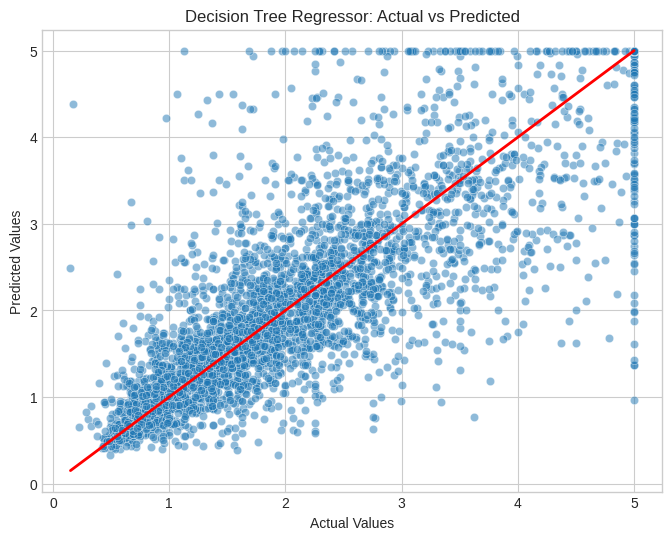

In [49]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # 45-degree line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Decision Tree Regressor: Actual vs Predicted")
plt.show()